In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

imagepath = input("Enter the path to the image: ")
# Load the image
image = cv2.imread(imagepath)
#output_directory = os.path.dirname(imagepath)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

Enter the path to the image:  E:\Shwetabh\support cases\WISPR\2024_06-07 WISPR - Transit_Level - Booth\2024_06-07 WISPR - Transit_Level - Booth\Booth 3R RESEPI-A8437C-2024-05-01-12-23-18 chris vantassel\camera\00000000000000003282764104481476_1398601661143834_1398601661150195.jpg


In [2]:
def orb_detector_descriptor(image):
    """
    Applies the ORB (Oriented FAST and Rotated BRIEF) feature detector and descriptor to an input image.

    :param image: Input image.
    :type image: numpy.ndarray
    :return: Keypoints and descriptors.
    :rtype: tuple(numpy.ndarray, numpy.ndarray)
    """
    # Create the ORB detector
    orb = cv2.ORB_create()

    # Detect keypoints
    keypoints, descriptors = orb.detectAndCompute(image, None)

    return keypoints, descriptors

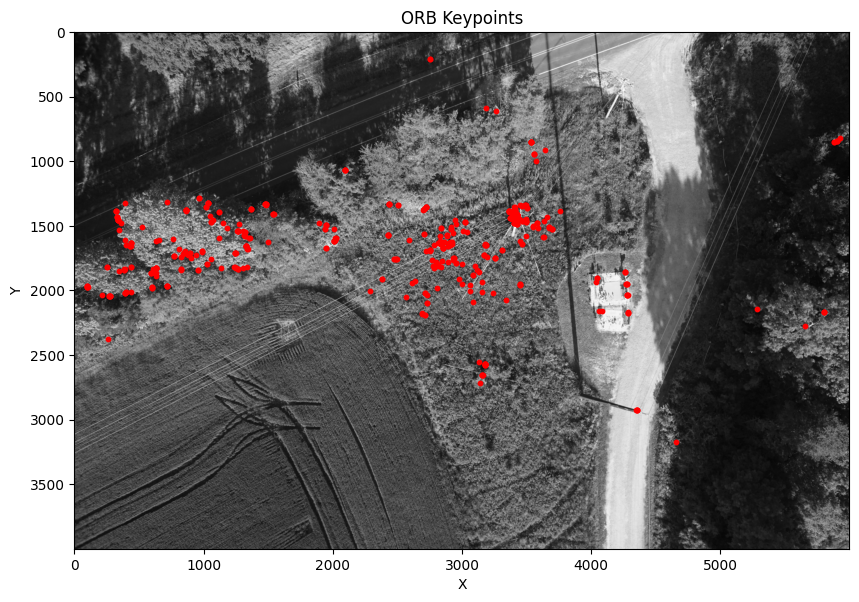

In [3]:
keypoints, descriptors = orb_detector_descriptor(gray_image)

image_rgb = cv2.cvtColor(gray_image, cv2.COLOR_BGR2RGB)
plt.figure()
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the image
ax.imshow(image_rgb)

# Plot the keypoints
ax.scatter([kp.pt[0] for kp in keypoints], [kp.pt[1] for kp in keypoints], color='r', s=10)

# Add title and axis labels
ax.set_title('ORB Keypoints')
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Show the plot
plt.show()

In [4]:
ip2 = input("Enter the path to the image: ")
# Load the image
im2 = cv2.imread(ip2)
#output_directory = os.path.dirname(imagepath)
gi2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

Enter the path to the image:  E:\Shwetabh\support cases\WISPR\2024_06-07 WISPR - Transit_Level - Booth\2024_06-07 WISPR - Transit_Level - Booth\Booth 3R RESEPI-A8437C-2024-05-01-12-23-18 chris vantassel\camera\00000000000000003282764104481476_1398601664503533_1398601664509887.jpg


<Figure size 640x480 with 0 Axes>

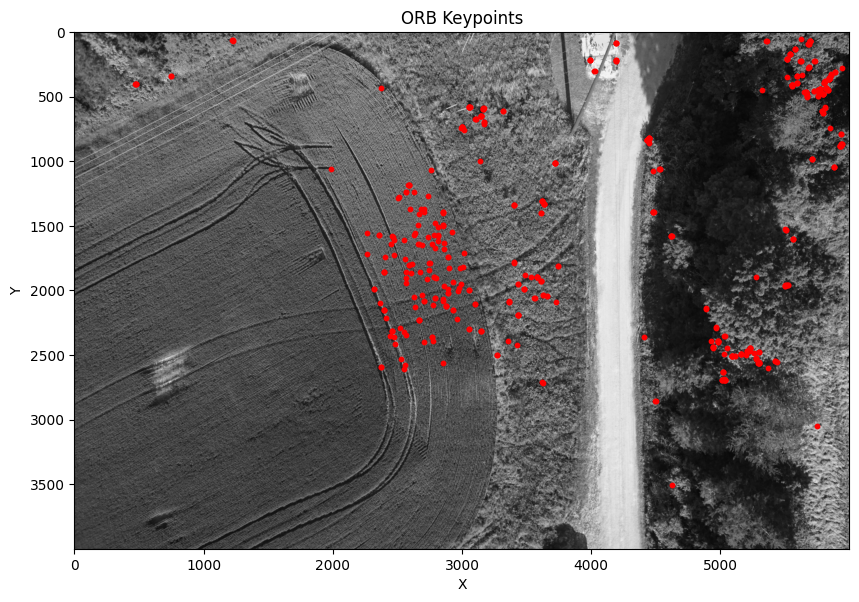

In [5]:
key2, desc2 = orb_detector_descriptor(gi2)

ci2 = cv2.cvtColor(gi2, cv2.COLOR_BGR2RGB)
plt.figure()
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the image
ax.imshow(ci2)

# Plot the keypoints
ax.scatter([kp.pt[0] for kp in key2], [kp.pt[1] for kp in key2], color='r', s=10)

# Add title and axis labels
ax.set_title('ORB Keypoints')
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Show the plot
plt.show()

In [11]:
# Create a Brute-Force Matcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match the descriptors
matches = bf.match(descriptors, desc2)

# Sort the matches by distance
matches = sorted(matches, key=lambda x: x.distance)

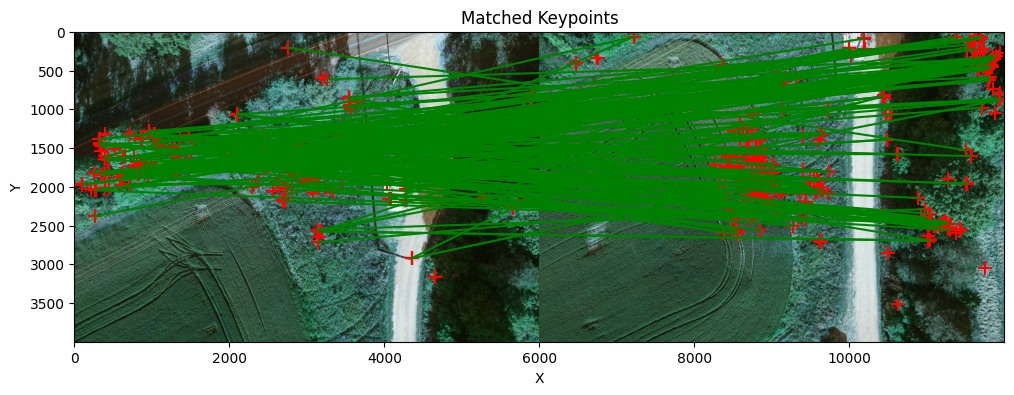

In [14]:
# Get the keypoint coordinates
x_positions_1 = [kp.pt[0] for kp in keypoints]
y_positions_1 = [kp.pt[1] for kp in keypoints]
x_positions_2 = [kp.pt[0] for kp in key2]
y_positions_2 = [kp.pt[1] for kp in key2]

# Create a combined image and shift the x positions of the second image
combined_img = np.concatenate((image, im2), axis=1)
x_positions_2_shifted = [x + image.shape[1] for x in x_positions_2]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the combined image
ax.imshow(combined_img)

# Draw lines between matched descriptors
for match in matches:
    # Get the keypoint indices from the match
    query_idx = match.queryIdx
    train_idx = match.trainIdx

    # Plot a line between the matched keypoints
    ax.plot([x_positions_1[query_idx], x_positions_2_shifted[train_idx]], [y_positions_1[query_idx], y_positions_2[train_idx]], c='g')

# Plot the keypoints
ax.scatter(x_positions_1, y_positions_1, c='r', s=100, marker='+')
ax.scatter(x_positions_2_shifted, y_positions_2, c='r', s=100, marker='+')

# Add title and axis labels
ax.set_title('Matched Keypoints')
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Show the plot
plt.show()

In [27]:
from scipy.linalg import lstsq

def estimate_ground_plane(pts1, pts2):
    """
    Estimate the ground plane parameters from the 2D keypoint coordinates using RANSAC.

    :param pts1: 2D keypoint coordinates from the first image.
    :type pts1: np.ndarray
    :param pts2: 2D keypoint coordinates from the second image.
    :type pts2: np.ndarray
    :return: Normal vector and distance of the ground plane from the origin.
    :rtype: tuple(np.ndarray, float) or (None, None)
    """
    # Combine the 2D keypoint coordinates
    all_pts = np.concatenate((pts1, pts2), axis=0)

    # Fit a plane to the 2D points using RANSAC
    best_inliers = 0
    best_normal = None
    best_distance = 0

    for i in range(100):
        # Randomly select 3 points to define a plane
        sample_idx = np.random.choice(len(all_pts), 3, replace=False)
        sample_pts = all_pts[sample_idx]

        # Compute the normal vector of the plane
        normal = np.cross(sample_pts[1] - sample_pts[0], sample_pts[2] - sample_pts[0])
        normal /= np.linalg.norm(normal)

        # Compute the distance of the plane from the origin
        distance = np.dot(normal, sample_pts[0])

        # Count the number of inliers
        inliers = 0
        dists = np.abs(np.dot(all_pts, normal.T) - distance)
        if np.all(dists < 0.1):
            inliers = len(all_pts)

        # Update the best plane parameters if we found more inliers
        if inliers > best_inliers:
            best_inliers = inliers
            best_normal = normal
            best_distance = distance

    # Return the best plane parameters if we found a good fit, otherwise return None
    if best_inliers > 0:
        return best_normal, best_distance
    else:
        return None, None

def assign_3d_coordinates(pts2d, normal, distance, camera_height):
    """
    Assign 3D coordinates to the 2D keypoints based on the estimated ground plane and the camera height.

    :param pts2d: 2D keypoint coordinates.
    :type pts2d: np.ndarray
    :param normal: Normal vector of the ground plane.
    :type normal: np.ndarray
    :param distance: Distance of the ground plane from the origin.
    :type distance: float
    :param camera_height: Height of the camera above the ground plane.
    :type camera_height: float
    :return: 3D coordinates of the keypoints.
    :rtype: np.ndarray
    """
    # Assign 3D coordinates based on the ground plane and the camera height
    pts3d = np.zeros((len(pts2d), 3))
    pts3d[:, 0] = pts2d[:, 0]
    pts3d[:, 1] = pts2d[:, 1]
    pts3d[:, 2] = camera_height - (normal[0] * pts2d[:, 0] + normal[1] * pts2d[:, 1] + distance) / normal[2]
    return pts3d

In [28]:
# Get the 2D keypoint coordinates
pts1 = np.float32([keypoints[m.queryIdx].pt for m in matches])
pts2 = np.float32([key2[m.trainIdx].pt for m in matches])

# Estimate the ground plane parameters
normal, distance = estimate_ground_plane(pts1, pts2)

# Estimate the ground plane parameters
normal, distance = estimate_ground_plane(pts1, pts2)

if normal is not None and distance is not None:
    # Assign 3D coordinates to the keypoints using the camera height
    camera_height = 50  # Assuming the camera is about 50 meters above the ground
    pts3d = assign_3d_coordinates(pts1, normal, distance, camera_height)

    # Estimate the camera pose
    _, rvec, tvec, _ = cv2.solvePnPRansac(pts3d, pts2, camera_matrix, dist_coeffs)

    # Calculate the rotation matrix from the rotation vector
    R, _ = cv2.Rodrigues(rvec)

    # Calculate the translation vector
    t = tvec.reshape(3,)

    # Print the estimated camera pose
    print("Rotation:")
    print(R)
    print("Translation:")
    print(t)
else:
    print("Unable to estimate the ground plane parameters.")

Unable to estimate the ground plane parameters.


C:\Users\ldwil\AppData\Local\Temp\ipykernel_24040\1698540909.py:28: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  normal = np.cross(sample_pts[1] - sample_pts[0], sample_pts[2] - sample_pts[0])
